## RNNs: How to Implement A Basic RNN

### Read In, Clean, And Split The Data

In [1]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('data/spam.csv', encoding='latin-1').drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
messages.columns = ['label', 'text']

labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'], labels, test_size=0.2)

### Prep Data For Modeling

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
## Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [4]:
# USe that tokenizer to transform the text messages in the training and testing set
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [5]:
# What do these sequences look like?
X_train_seq[0]

[1, 60, 81, 178, 125, 44, 60, 52, 863, 647, 36, 753]

In [6]:
# Pad the sequences so each sequence is the same length
X_train_seq_pad = pad_sequences(X_train_seq, 50)
X_test_seq_pad = pad_sequences(X_test_seq, 50)

In [7]:
# What do these padded sequences look like?
X_train_seq_pad[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
        60,  81, 178, 125,  44,  60,  52, 863, 647,  36, 753])

### Build Model

In [8]:
# Import the tools needed from keras and define functions to calculate recall and precision
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential

def recall_m(y_test, y_pred):
    tp = K.sum(K.round(K.clip(y_pred*y_test, 0, 1)))
    possible_pos = K.sum(K.round(K.clip(y_test, 0, 1)))
    recall = tp / (possible_pos + K.epsilon())
    return recall

def precision_m(y_test, y_pred):
    tp = K.sum(K.round(K.clip(y_pred*y_test, 0, 1)))
    predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (predicted_pos + K.epsilon())
    return precision

In [12]:
# Construct a simple RNN model
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          254656    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 264,065
Trainable params: 264,065
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy', recall_m, precision_m])

In [18]:
# Fit the RNN model
history = model.fit(X_train_seq_pad, y_train,
                   batch_size=32, epochs=10,
                   validation_data=(X_test_seq_pad, y_test))

Epoch 1/10
140/140 [==============================] - 4s 30ms/step - loss: 0.2410 - accuracy: 0.9210 - recall_m: 0.4021 - precision_m: 0.4914 - val_loss: 0.0740 - val_accuracy: 0.9830 - val_recall_m: 0.8027 - val_precision_m: 0.9143
Epoch 2/10
140/140 [==============================] - 3s 22ms/step - loss: 0.0345 - accuracy: 0.9912 - recall_m: 0.9468 - precision_m: 0.9773 - val_loss: 0.0460 - val_accuracy: 0.9883 - val_recall_m: 0.8635 - val_precision_m: 0.9240
Epoch 3/10
140/140 [==============================] - 3s 20ms/step - loss: 0.0127 - accuracy: 0.9969 - recall_m: 0.9664 - precision_m: 0.9737 - val_loss: 0.0497 - val_accuracy: 0.9839 - val_recall_m: 0.8706 - val_precision_m: 0.8907
Epoch 4/10
140/140 [==============================] - 3s 21ms/step - loss: 0.0049 - accuracy: 0.9991 - recall_m: 0.9943 - precision_m: 0.9988 - val_loss: 0.0525 - val_accuracy: 0.9865 - val_recall_m: 0.8635 - val_precision_m: 0.9002
Epoch 5/10
140/140 [==============================] - 3s 20ms/step -

In [19]:
pd.DataFrame(history.history)

,loss,accuracy,recall_m,precision_m,val_loss,val_accuracy,val_recall_m,val_precision_m
0,0.241040,0.921023,0.402112,0.491429,0.074037,0.982960,0.802744,0.914286
1,0.034454,0.991250,0.946780,0.977296,0.045987,0.988341,0.863492,0.924048
2,0.012748,0.996859,0.966420,0.973741,0.049674,0.983856,0.870635,0.890714
3,0.004929,0.999103,0.994345,0.998810,0.052458,0.986547,0.863492,0.900238
4,0.004348,0.998654,0.993622,0.995357,0.083729,0.982960,0.811746,0.937143
5,0.001481,0.999776,0.984286,0.985714,0.072542,0.985650,0.835556,0.937143
6,0.000859,0.999776,0.982143,0.985714,0.077159,0.982960,0.828413,0.924048
7,0.000198,1.000000,0.971429,0.971429,0.087469,0.984753,0.826032,0.937143
8,0.000097,1.000000,1.000000,1.000000,0.087045,0.984753,0.826032,0.937143
9,0.000069,1.000000,0.992857,0.992857,0.089853,0.984753,0.826032,0.937143


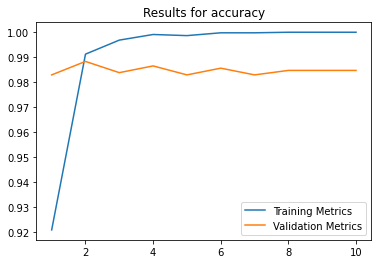

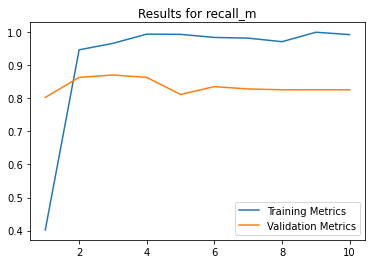

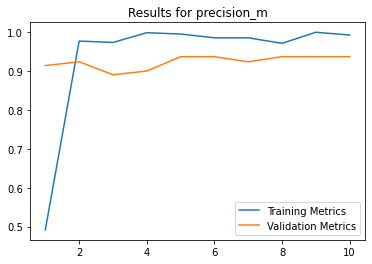

In [21]:
# Plot the evaluation metrics by each epuch for the model to see if we over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'recall_m', 'precision_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)
    
    plt.figure()
    plt.plot(epochs, acc, label='Training Metrics')
    plt.plot(epochs, val_acc, label='Validation Metrics')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()